In [1]:
import sys
sys.path.append('../Utils')

import joblib
import pandas as pd
from sklearn import metrics, cluster, model_selection, decomposition, tree, pipeline, preprocessing, neighbors, compose, feature_selection, linear_model, ensemble
from scipy import stats
import numpy as np
from utils import ReorderTransformer, LabelingTransformer, CustomMetricPipeline
import matplotlib.pyplot as plt

%matplotlib inline

import sys
import os
import torch

SEED = 42

np.random.seed(SEED)

In [2]:
DATASET_DIR = '../Dataset'

## Dataset

In [3]:
train_X, train_y = joblib.load(os.path.join(DATASET_DIR, 'attn_train.jl'))
dev_X, dev_y = joblib.load(os.path.join(DATASET_DIR, 'attn_dev.jl'))

In [4]:
X = np.concatenate((train_X, dev_X))
y = np.concatenate((train_y, dev_y))

In [5]:
train_df = pd.read_csv(os.path.join(DATASET_DIR, 'n_train.csv'))
dev_df = pd.read_csv(os.path.join(DATASET_DIR, 'n_dev.csv'))

df = pd.concat((train_df, dev_df))

In [6]:
train_indices = np.arange(0, train_X.shape[0])
dev_indices = np.arange(train_X.shape[0], train_X.shape[0] + dev_X.shape[0])

In [7]:
ds_info = joblib.load(os.path.join(DATASET_DIR, 'ds_info.jl'))

columns = ds_info['columns']
numerical_cols = ds_info['numerical_columns']
categorical_cols = ds_info['categorical_columns']
label_col = ds_info['target_column']

In [8]:
features = [col for col in columns]
features.remove(label_col)
features = np.array(features)

## Used methods

In [9]:
def get_preprocessing_pipe(categorical_cols, numerical_cols):
    categorical_transformer = pipeline.Pipeline(steps=[
        ('label', LabelingTransformer())])

    numerical_transformer = pipeline.Pipeline(steps=[
        ('scaler', preprocessing.MinMaxScaler())
    ])

    preprocessing_pipe = pipeline.Pipeline([
        ('reordering', ReorderTransformer(categorical_columns=categorical_cols, numerical_columns=numerical_cols)),
        ('columns_transformer', compose.ColumnTransformer(
            remainder='drop', 
            transformers=[
                ('categorical_transformer', categorical_transformer , categorical_cols),
                ('numerical_transformer', numerical_transformer , numerical_cols)
            ])
        )
    ])
    
    return preprocessing_pipe

In [10]:
def train_tree_model(preprocessing_pipe, name):
    
    MODEL_DIR = '../Models/tree'
    
    pipe = CustomMetricPipeline(metrics.balanced_accuracy_score, [
        ('preprocessing', preprocessing_pipe),
        ('classifier', tree.DecisionTreeClassifier(random_state=SEED))
    ])

    param_grid = {
        'classifier__max_depth': np.arange(1, 50)
    }
    scoring = {'acc': 'balanced_accuracy'}

    clf = model_selection.GridSearchCV(
        pipe, 
        param_grid, 
        cv=((train_indices, dev_indices),),
        scoring=scoring,
        refit='acc'
    )

    _ = clf.fit(df.drop(label_col, axis=1), df[label_col])

    clf.best_params_

    pipe.set_params(**clf.best_params_)
    pipe = pipe.fit(train_df.drop(label_col, axis=1), train_df[label_col])
    
    
    joblib.dump(pipe, os.path.join(MODEL_DIR, name)) 
    
    return pipe

In [11]:
def train_knn_model(preprocessing_pipe, name):
    
    MODEL_DIR = '../Models/knn'
    
    pipe = CustomMetricPipeline(metrics.balanced_accuracy_score, [
        ('preprocessing', preprocessing_pipe),
        ('classifier', neighbors.KNeighborsClassifier())
    ])

    param_grid = {
        'classifier__n_neighbors': np.arange(1, 25)
    }
    scoring = {'acc': 'balanced_accuracy'}

    clf = model_selection.GridSearchCV(
        pipe, 
        param_grid, 
        cv=((train_indices, dev_indices),),
        scoring=scoring,
        refit='acc'
    )

    _ = clf.fit(df.drop(label_col, axis=1), df[label_col])

    clf.best_params_

    pipe.set_params(**clf.best_params_)
    pipe = pipe.fit(train_df.drop(label_col, axis=1), train_df[label_col])
        
    joblib.dump(pipe, os.path.join(MODEL_DIR, name)) 
        
    return pipe

# Attention based

## Attention visualization

In [12]:
attn_mat = train_X.mean(axis=0)

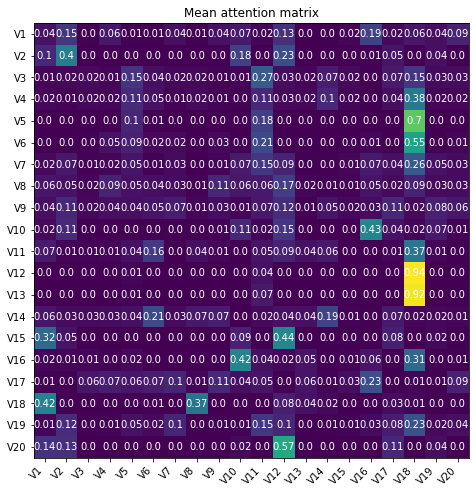

In [13]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.imshow(attn_mat)

ax.set(title='Mean attention matrix')

ax.set_xticks(np.arange(features.shape[0]))
ax.set_yticks(np.arange(features.shape[0]))

ax.set_xticklabels(features, rotation=45, ha='right')
ax.set_yticklabels(features)    

for i in range(features.shape[0]):
    for j in range(features.shape[0]):
        text = ax.text(j, i, np.around(attn_mat[i, j], decimals=2), ha="center", va="center", color="w")


fig.savefig('Mean attention.png')
plt.show()

## Feature selection

In [14]:
def attn_feature_selection(attn_mat, entropy_scaler=0.95, prob_scaler=1.5):
    # Uniform probability distribution and entropy
    uniform_prob = 1 / attn_mat.shape[0]
    max_entropy = -np.log(uniform_prob)
    
    # Entropy per row (each row is a distribution probability)
    entropy = -(attn_mat * np.log(attn_mat + 1e-15)).sum(axis=1)
    
    # Select those rows where attention entropy is lower than entropy_scaler times max_entropy
    rows_indices = np.argwhere(entropy < entropy_scaler * max_entropy).flatten()
    
    # Select those cells where probability is at most prob_threshold
    sub_mat_indices = np.argwhere(uniform_prob * prob_scaler < attn_mat[rows_indices]) 
    
    # Replace sub matrix indices with original indices
    sub_mat_indices[:, 0] = rows_indices[sub_mat_indices[:, 0]]
    
    # Create feature selection mask
    # mask = np.zeros(attn_mat.shape)
    # mask[sub_mat_indices[:, 0], sub_mat_indices[:, 1]] = 1
    
    return sub_mat_indices

In [15]:
def attn_columns_selection(columns, attn_indices):
    
    attn_features = columns[np.unique(attn_indices.flatten())]
    
    return attn_features

In [16]:
attn_indices = attn_feature_selection(attn_mat, entropy_scaler=0.7, prob_scaler=2)
attn_features = attn_columns_selection(features, attn_indices)

In [17]:
attn_features

array(['V1', 'V2', 'V5', 'V6', 'V8', 'V10', 'V11', 'V12', 'V13', 'V15',
       'V16', 'V17', 'V18', 'V20'], dtype='<U3')

### Load dataset

In [18]:
attn_features_list = attn_features.tolist()

In [19]:
columns = attn_features_list.copy()
columns.append(label_col)

attn_numerical_cols = list(set(numerical_cols) & set(attn_features_list))
attn_categorical_cols = list(set(categorical_cols) & set(attn_features_list))

In [20]:
preprocessing_pipe = get_preprocessing_pipe(attn_categorical_cols, attn_numerical_cols)

### Decision tree

In [21]:
pipe = train_tree_model(preprocessing_pipe, 'tree_attn_fs.jl')

print('Train score: {}'.format(pipe.score(train_df.drop(label_col, axis=1), train_df[label_col])))
print('Dev score: {}'.format(pipe.score(dev_df.drop(label_col, axis=1), dev_df[label_col])))

Train score: 0.7620834996590236
Dev score: 0.6553944390682506


### KNN

In [22]:
pipe = train_knn_model(preprocessing_pipe, 'knn_attn_fs.jl')

print('Train score: {}'.format(pipe.score(train_df.drop(label_col, axis=1), train_df[label_col])))
print('Dev score: {}'.format(pipe.score(dev_df.drop(label_col, axis=1), dev_df[label_col])))

Train score: 0.6800093382262364
Dev score: 0.626854469395064


# Testing other methods

In [23]:
preprocessing_pipe = get_preprocessing_pipe(categorical_cols, numerical_cols)
preprocessed_train_df = preprocessing_pipe.fit_transform(train_df.drop(label_col, axis=1))

In [24]:
n_features = len(attn_features)

### Pearson correlation

In [25]:
def get_selected_features(df, y, columns, num_feats):
    features = []
    corr_coefs = []
    
    for i in range(df.shape[1]):
        coef = np.corrcoef(df[:, i], y)[0, 1]
        corr_coefs.append(coef)
    
    # replace NaN with 0
    corr_coefs = [0 if np.isnan(i) else i for i in corr_coefs]
    
    # feature name
    sorted_indices = np.argsort(np.abs(corr_coefs))
    corr_feature = columns[sorted_indices][-num_feats:]
        
    # feature selection? 0 for not select, 1 for select
    corr_support = [True if i in corr_feature else False for i in columns]
    
    return corr_support, corr_feature

_, pearson_features = get_selected_features(preprocessed_train_df, train_y, features, num_feats=n_features)
pearson_features = pearson_features.tolist()

In [26]:
preprocessing_pipe = get_preprocessing_pipe(
    list(set(categorical_cols) & set(pearson_features)), 
    list(set(numerical_cols) & set(pearson_features))
)

In [27]:
pipe = train_tree_model(preprocessing_pipe, 'tree_pearson_fs.jl')

print('Train score: {}'.format(pipe.score(train_df.drop(label_col, axis=1), train_df[label_col])))
print('Dev score: {}'.format(pipe.score(dev_df.drop(label_col, axis=1), dev_df[label_col])))

Train score: 0.9516539370190401
Dev score: 0.9323018660895936


In [28]:
pipe = train_knn_model(preprocessing_pipe, 'knn_pearson_fs.jl')

print('Train score: {}'.format(pipe.score(train_df.drop(label_col, axis=1), train_df[label_col])))
print('Dev score: {}'.format(pipe.score(dev_df.drop(label_col, axis=1), dev_df[label_col])))

Train score: 0.8967050792585127
Dev score: 0.8458228243559363


### Chi-Squared

In [29]:
chi_selector = feature_selection.SelectKBest(feature_selection.chi2, k=n_features)
chi_selector.fit(preprocessed_train_df, train_y)
chi_support = chi_selector.get_support()

chi_features = features[chi_support].tolist()
chi_features

['V4',
 'V5',
 'V7',
 'V9',
 'V10',
 'V11',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20']

In [30]:
preprocessing_pipe = get_preprocessing_pipe(
    list(set(categorical_cols) & set(chi_features)), 
    list(set(numerical_cols) & set(chi_features))
)

In [31]:
pipe = train_tree_model(preprocessing_pipe, 'tree_chi_fs.jl')

print('Train score: {}'.format(pipe.score(train_df.drop(label_col, axis=1), train_df[label_col])))
print('Dev score: {}'.format(pipe.score(dev_df.drop(label_col, axis=1), dev_df[label_col])))

Train score: 0.9516539370190401
Dev score: 0.9351535771162096


In [32]:
pipe = train_knn_model(preprocessing_pipe, 'knn_chi_fs.jl')

print('Train score: {}'.format(pipe.score(train_df.drop(label_col, axis=1), train_df[label_col])))
print('Dev score: {}'.format(pipe.score(dev_df.drop(label_col, axis=1), dev_df[label_col])))

Train score: 0.8446101798518668
Dev score: 0.8313051959432172


### Tree based (Random forest)

In [33]:
embeded_rf_selector = feature_selection.SelectFromModel(
    ensemble.RandomForestClassifier(n_estimators=100), 
    max_features=n_features
)

embeded_rf_selector.fit(preprocessed_train_df, train_y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_features = features[embeded_rf_support].tolist()
embeded_rf_features

['V7', 'V9']

In [34]:
preprocessing_pipe = get_preprocessing_pipe(
    list(set(categorical_cols) & set(embeded_rf_features)),
    list(set(numerical_cols) & set(embeded_rf_features))
)

In [35]:
preprocessing_pipe.fit(train_df.drop(label_col, axis=1), train_df[label_col])

Pipeline(steps=[('reordering',
                 ReorderTransformer(categorical_columns=[],
                                    numerical_columns=['V9', 'V7'])),
                ('columns_transformer',
                 ColumnTransformer(transformers=[('categorical_transformer',
                                                  Pipeline(steps=[('label',
                                                                   LabelingTransformer())]),
                                                  []),
                                                 ('numerical_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['V9', 'V7'])]))])

In [36]:
pipe = train_tree_model(preprocessing_pipe, 'tree_tb_fs.jl')

print('Train score: {}'.format(pipe.score(train_df.drop(label_col, axis=1), train_df[label_col])))
print('Dev score: {}'.format(pipe.score(dev_df.drop(label_col, axis=1), dev_df[label_col])))

Train score: 0.9194618201582927
Dev score: 0.9214855566646601


In [37]:
pipe = train_knn_model(preprocessing_pipe, 'knn_tb_fs.jl')

print('Train score: {}'.format(pipe.score(train_df.drop(label_col, axis=1), train_df[label_col])))
print('Dev score: {}'.format(pipe.score(dev_df.drop(label_col, axis=1), dev_df[label_col])))

Train score: 0.9198163425732104
Dev score: 0.930040689744508
